In [10]:
#!pip install -r requirements.txt

In [3]:
import pandas as pd

train_df = pd.read_csv("train_test_datasets/train_balanced_PROMPT2.csv")
test_df = pd.read_csv("train_test_datasets/test_PROMPT2.csv")

print(train_df["label"].value_counts())
print(test_df["label"].value_counts())
print(train_df["label"].unique())
print(test_df["label"].unique())

print(train_df["label"].dtype, test_df["label"].dtype)

label
0    1896
1    1896
Name: count, dtype: int64
label
0    812
1     88
Name: count, dtype: int64
[0 1]
[0 1]
int64 int64


In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback, get_scheduler
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.optim as optim
import numpy as np

# Load a custom CSV file
data_files = {"train": "train_test_datasets/train_balanced_PROMPT2.csv", "test": "train_test_datasets/test_PROMPT2.csv"}
dataset = load_dataset("csv", data_files=data_files)

# -----------------------------------
# INITIAL INSPECTION
# -----------------------------------

# Inspect the first few samples
print(dataset["train"][0])

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") #NOTE: Using base model. Increase size for better performance
sample_text = "The purpose of this organization is to provide community services."
tokens = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128)
print(tokens)

def tokenize_function(examples):
    return tokenizer(examples["mission"], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets["train"][0])

labels = dataset['train']['label']
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
print(class_weights)

Generating train split: 3792 examples [00:00, 258892.48 examples/s]
Generating test split: 900 examples [00:00, 173374.07 examples/s]


{'mission': 'to promote student welfare to strengthen the bond between home school and community and to supplement student education needs', 'label': 0, 'reason': 'The mission focuses on student welfare and education without any religious or faith-based language.'}
{'input_ids': [101, 1996, 3800, 1997, 2023, 3029, 2003, 2000, 3073, 2451, 2578, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Map: 100%|██████████| 900/900 [00:00<00:00, 26870.49 examples/s]

{'mission': 'to promote student welfare to strengthen the bond between home school and community and to supplement student education needs', 'label': 0, 'reason': 'The mission focuses on student welfare and education without any religious or faith-based language.', 'input_ids': [101, 2000, 5326, 3076, 7574, 2000, 12919, 1996, 5416, 2090, 2188, 2082, 1998, 2451, 1998, 2000, 12448, 3076, 2495, 3791, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[1. 1.]


In [6]:
# -----------------------------------
# SETTING MODEL AND LABELS
# -----------------------------------

# Load model with binary classification head
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
print(model.config)

# Freeze all layers
for param in model.bert.parameters(): # encoder parameters
    param.requires_grad = False

# Unfreeze the 3 encoder layers
for name, param in model.bert.named_parameters():
    if any(f"layer.{i}." in name for i in range(9, 12)):  # unfreeze last 3 instead of just the head
        param.requires_grad = True

# Keep the classification head trainable, always
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

optimizer = optim.AdamW(model.parameters())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Trainable parameters: 21265154


In [7]:
# -----------------------------------
# SETTING PARAMETERS FOR TRAINING
# -----------------------------------

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=500,
    fp16=True,
    # push_to_hub=True
)

In [12]:
# -----------------------------------
# SETTING CUSTOM TRAINER AND CE LOSS
# -----------------------------------
import torch.nn as nn
import torch

class_weights = np.array([1.0, 1.1]) # manually adapting class weights to increase class 1 identification

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float().to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [13]:
# -----------------------------------
# TRAINING AND EVALUATION
# -----------------------------------

metric = load('f1') # accuracy does not work great for imbalanced datasets, f1 is better

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # This ensures that each batch is dynamically padded to the longest seq. in the batch

num_training_steps = len(tokenized_datasets["train"]) // training_args.per_device_train_batch_size
num_training_steps *= training_args.num_train_epochs

scheduler = get_scheduler( # this helps start with a small learning rate, increase it gradually and decay afterwards
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps # number of batches * number of epochs
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics
)



trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=4)) # early stop to reach peak performance and avoid overfitting
trainer.train()
trainer.save_model("./my_model_prompt2")

results = trainer.evaluate()
print(results)

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_76472/289320375.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.539095,0.953333,0.700000,0.942308,0.556818
2,No log,0.518258,0.902222,0.000000,0.000000,0.000000
3,0.644800,0.658037,0.902222,0.000000,0.000000,0.000000
4,0.644800,0.904210,0.097778,0.178138,0.097778,1.000000
5,0.717100,0.254838,0.952222,0.790244,0.692308,0.920455
6,0.717100,0.104219,0.977778,0.894737,0.833333,0.965909
7,0.304300,0.107525,0.981111,0.903955,0.898876,0.909091
8,0.304300,0.084779,0.982222,0.913978,0.867347,0.965909
9,0.097700,0.079469,0.983333,0.918919,0.876289,0.965909
10,0.097700,0.081051,0.983333,0.918919,0.876289,0.965909


/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12

{'eval_loss': 0.07946936041116714, 'eval_accuracy': 0.9833333333333333, 'eval_f1': 0.918918918918919, 'eval_precision': 0.8762886597938144, 'eval_recall': 0.9659090909090909, 'eval_runtime': 12.9402, 'eval_samples_per_second': 69.551, 'eval_steps_per_second': 4.405, 'epoch': 10.0}


/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       812
           1       0.88      0.97      0.92        88

    accuracy                           0.98       900
   macro avg       0.94      0.98      0.95       900
weighted avg       0.98      0.98      0.98       900



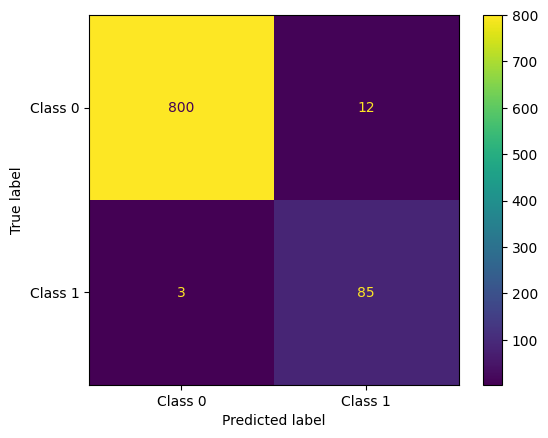

In [15]:
# -----------------------------------
# CLASSIFICATION REPORT AND CONFUSION MATRIX
# -----------------------------------

# Generate predictions
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_datasets["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_datasets["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot();

In [16]:
for idx, (pred, label) in enumerate(zip(predicted_labels, tokenized_datasets["test"]["label"])):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(tokenized_datasets["test"][idx]["mission"])

Index: 41, Predicted: 0, Actual: 1
the organization's mission is to educate students in mind body and spirit in order to: 1) prepare them for the challenges and opportunities of higher education; 2) help them learn to love and respect themselves and their fellow students and to care for those in less fortunate circumstances; 3) teach them to be responsible stewards of our natural heritage; 4) remind them that one man or woman of principle can always make a difference
Index: 87, Predicted: 1, Actual: 0
bates is a college of the liberal arts and sciences and is a coeducational nonsectarian residential college with special commitments to academic rigor and to assuring in all of its efforts the dignity of each individual and access to its programs and opportunities by qualified learners bates offers a curriculum and faculty that challenge students to attain intellectual achievements and to develop powers of critical assessment analysis expression aesthetic sensibility and independent thoug